# **Meflah wided _22214601**

#Fature Maps
Dans ce notebook, nous affichons les feature maps pour le modele-tiger (Amilioré)



# 0-Installation des libraire et mise en palce de google drive

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle

In [ ]:
# Importation des différentes librairies utiles pour le notebook
#Pour ignorer les warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std
from scipy.stats import randint

# librairie affichage
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from PIL import Image

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,img_to_array, load_img #from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.models import load_model
from keras.models import Model
from sklearn.model_selection import KFold
from keras.layers import Dense
import os  #pour accéder aux fonctionnalité systèmes
import sys
from os import listdir
from os.path import isfile, join
import cv2  # Library to solve computer vision problems
import glob  # = global is used to return all file paths that match a specific pattern

In [ ]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
my_local_drive='/content/gdrive/MyDrive/ML2_prjt2023'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/MyDrive/ML2_prjt2023


'/content/gdrive/MyDrive/ML2_prjt2023'

## Récupération des jeux de données

In [ ]:
#pour télécharger le zip file
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2023-12-03 19:49:43--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.1’

Tiger-Fox-Elephant.  14%[=>                  ]   1.02M  1.48MB/s               ^C


In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

KeyboardInterrupt: ignored

##Fonctions Utils

In [ ]:
IMG_SIZE=124
COLUMNS = 16

In [ ]:
 """
 Téléchargement de jeux d'entrainement
 @Param path_data: le chemin vers notre répertoire de données
 @Param list_classes: la liste de nom de classe volue
 @Return training_data
 """
 def create_training_data(path_data, list_classes):
  training_data=[]   #Tableau de retour
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])  # on remplit notre tableau
        except Exception as e:
          pass
  return training_data

 """
 Creation de jeux d'entrainement
 @Param path_data: le chemin vers notre répertoire de données
 @Param list_classes: la liste de nom de classe volue
 @Return X,y
 """
 def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)  #-1 The new shape should be compatible with the original shape.
      y=np.array(y)
      return X,y

 """
 Nettoyage de données : conversion en foat et normalisation
 @Param xtrain
 @Param xtest
 @Return xtrain_norm, xtest_norm
 """
 def clean_data(x):
    # convertion d'entier en float
    xtrain_norm = x.astype('float32')
    # normalisation entre 0 et 1
    xtrain_norm = xtrain_norm / 255.0
    return xtrain_norm

 """
 Affichage de données :
 @Param X
 @Param y
 """
 def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit, met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    plt.imshow(X[i],cmap=plt.cm.binary)
    plt.xlabel('classe ' + str(y[i]))

In [ ]:
def plot_curves(histories):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,top = 0.9, wspace = 0.25, hspace = 0)
  for i in range(len(histories)):
    # plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red',label='test')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
  plt.show()

##Affichage des feature mapas

In [ ]:


def define_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(124, 124, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Nouvelle couche de convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dropout(0.5))  # Première couche Dropout
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.7))  # Deuxième couche Dropout
    model.add(Dense(2, activation='sigmoid'))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model


Ici on examine les différentes couches du modèle

In [ ]:
from keras.optimizers import Adam
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 128)      

In [ ]:

print ("Le modèle a :", len(model.layers), " couches\n")


print ("Input du modèle : ", model.input)


layer_names = [layer.name for layer in model.layers]
print ("\nNom des couches : ", layer_names)


print ("\nFormat des différentes couches : ")
for i in range(len(model.layers)):
    layer = model.layers[i]
    print("format du layer [", i ,"] : ", layer.name , layer.output.shape)

Le modèle a : 11  couches

Input du modèle :  KerasTensor(type_spec=TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name='conv2d_3_input'), name='conv2d_3_input', description="created by layer 'conv2d_3_input'")

Nom des couches :  ['conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'max_pooling2d_4', 'conv2d_5', 'max_pooling2d_5', 'flatten_1', 'dropout_2', 'dense_2', 'dropout_3', 'dense_3']

Format des différentes couches : 
format du layer [ 0 ] :  conv2d_3 (None, 122, 122, 32)
format du layer [ 1 ] :  max_pooling2d_3 (None, 61, 61, 32)
format du layer [ 2 ] :  conv2d_4 (None, 59, 59, 64)
format du layer [ 3 ] :  max_pooling2d_4 (None, 29, 29, 64)
format du layer [ 4 ] :  conv2d_5 (None, 27, 27, 128)
format du layer [ 5 ] :  max_pooling2d_5 (None, 13, 13, 128)
format du layer [ 6 ] :  flatten_1 (None, 21632)
format du layer [ 7 ] :  dropout_2 (None, 21632)
format du layer [ 8 ] :  dense_2 (None, 128)
format du layer [ 9 ] :  dropout_3 (None, 128)
format du layer [ 10 ] :  dense_3 (No

In [ ]:
feature_map_layer1 = tf.keras.models.Model(inputs=model.inputs , outputs=model.layers[1].output)

In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger']

X, y = create_X_y(my_path, my_classes)

X = clean_data(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)


print ("X_train et X_test à l'origine : ", X_train.shape, ' ', X_test.shape)
print ("y_test et y_test à l'origine : ", y_train.shape, ' ', y_test.shape)

X_train et X_test à l'origine :  (80, 124, 124, 3)   (20, 124, 124, 3)
y_test et y_test à l'origine :  (80, 1)   (20, 1)


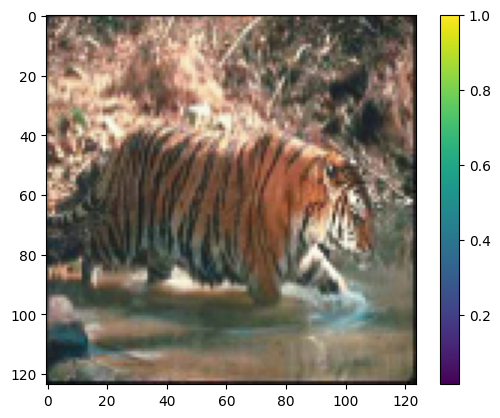

In [ ]:
numimage=10
plt.figure()
plt.imshow(cv2.cvtColor(X_train[numimage], cv2.COLOR_BGR2RGB))
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
my_image=X_train[numimage]

# extension des dimensions pour manipuler une seule image
my_image = np.expand_dims(my_image, axis=0)
my_image.shape

(1, 124, 124, 3)

In [ ]:
features = feature_map_layer1.predict(my_image)

1/1 [==============================] - 0s 199ms/step


In [ ]:
print (features.shape)

(1, 61, 61, 32)


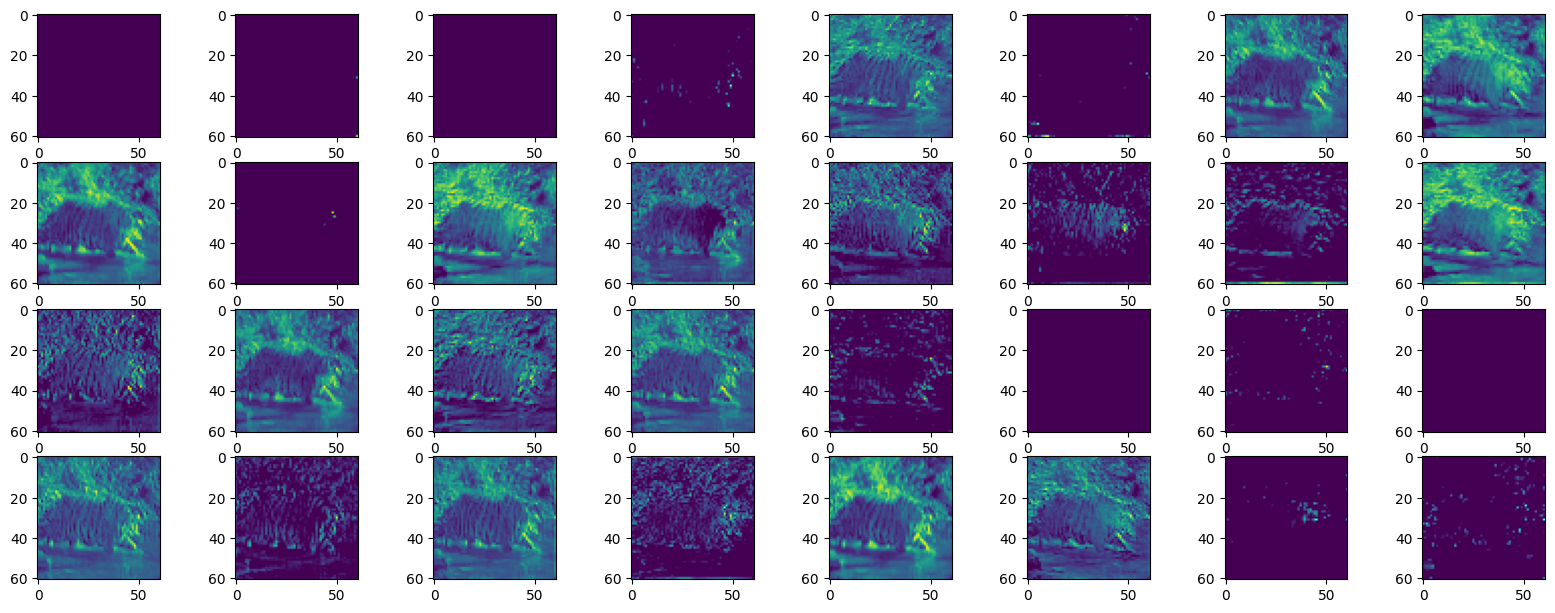

In [ ]:
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1])
pyplot.show()

In [ ]:
list_layer_conv=[0,2,4] #Liste d'indice

# Selection des couches correspondant aux convolutions
outputs = [model.layers[i].output for i in list_layer_conv]
feature_maps_model = tf.keras.models.Model(inputs=model.inputs , outputs=outputs)

feature_maps = feature_maps_model.predict(my_image)

1/1 [==============================] - 0s 238ms/step


In [ ]:
for i,fmap in zip(list_layer_conv,feature_maps):
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(layer_names[i] , fontsize=20)
    for i in range(1,features.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1])
plt.show()

Output hidden; open in https://colab.research.google.com to view.